In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/predict-the-success-of-bank-telemarketing/sample_submission.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv
/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv


In [2]:
# !pip install xgboost

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA



In [3]:
train=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/train.csv')
test=pd.read_csv('/kaggle/input/predict-the-success-of-bank-telemarketing/test.csv')


In [4]:
train

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target
0,2009-04-17,26,blue-collar,married,secondary,no,647,yes,no,cellular,357,2,331,1,other,no
1,2009-10-11,52,technician,married,secondary,no,553,yes,no,telephone,160,1,-1,0,NaN,no
2,2010-11-20,44,blue-collar,married,secondary,no,1397,no,no,cellular,326,1,-1,0,NaN,no
3,2009-09-01,33,admin.,married,secondary,no,394,yes,no,telephone,104,3,-1,0,NaN,no
4,2008-01-29,31,entrepreneur,single,tertiary,no,137,no,no,cellular,445,2,-1,0,NaN,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,2008-07-31,31,technician,single,secondary,no,0,yes,no,cellular,16,34,-1,0,NaN,no
39207,2009-07-31,59,admin.,married,primary,no,6187,no,no,cellular,114,4,-1,0,NaN,no
39208,2008-06-02,36,blue-collar,married,secondary,no,63,yes,no,NaN,56,8,-1,0,NaN,no
39209,2010-03-20,28,student,single,secondary,no,5916,no,no,cellular,93,5,-1,0,NaN,no


In [5]:
train.isnull().sum()

last contact date        0
age                      0
job                    229
marital                  0
education             1467
default                  0
balance                  0
housing                  0
loan                     0
contact              10336
duration                 0
campaign                 0
pdays                    0
previous                 0
poutcome             29451
target                   0
dtype: int64

# Categorical Columns
# job , martial , education , default , housing ,loan , contact , poutcome

# Job

 Number of null values :  229

---------------------------------------------------------------------------

Unique job :  ['blue-collar' 'technician' 'admin.' 'entrepreneur' 'unemployed'
 'management' 'services' 'student' 'self-employed' 'retired' 'housemaid'
 nan]

---------------------------------------------------------------------------

job value counts:  job
blue-collar      7776
management       7462
technician       6078
admin.           4116
services         3325
self-employed    1862
retired          1824
entrepreneur     1805
unemployed       1685
housemaid        1656
student          1393
Name: count, dtype: int64

---------------------------------------------------------------------------



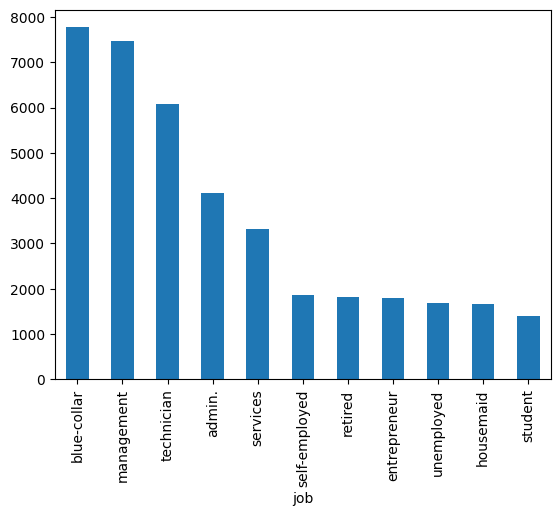


---------------------------------------------------------------------------



In [6]:

print(' Number of null values : ' , train['job'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print('Unique job : ' , train['job'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('job value counts: ' , train['job'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['job'].value_counts().plot(kind='bar')
plt.show()

print('')
print('---------------------------------------------------------------------------')
print('')


train['job'] = train['job'].replace(np.nan, 'blue-collar')









test['job'] = test['job'].replace(np.nan , 'blue-collar')

# martial

marital has no null values :  0

---------------------------------------------------------------------------

 Unique marital :  ['married' 'single' 'divorced']

---------------------------------------------------------------------------

marital value counts:  marital
married     22691
single      11250
divorced     5270
Name: count, dtype: int64

---------------------------------------------------------------------------



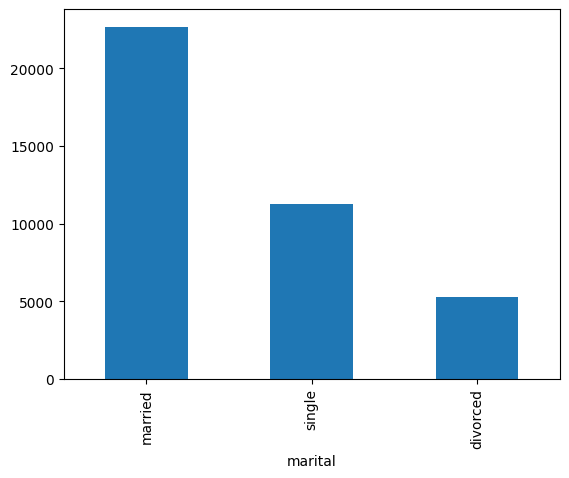

In [7]:
print('marital has no null values : ' , train['marital'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique marital : ' , train['marital'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('marital value counts: ' , train['marital'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['marital'].value_counts().plot(kind='bar')
plt.show()

# education

education has no null values :  1467

---------------------------------------------------------------------------

 Unique education :  ['secondary' 'tertiary' 'primary' nan]

---------------------------------------------------------------------------

education value counts:  education
secondary    19584
tertiary     11615
primary       6545
Name: count, dtype: int64

---------------------------------------------------------------------------



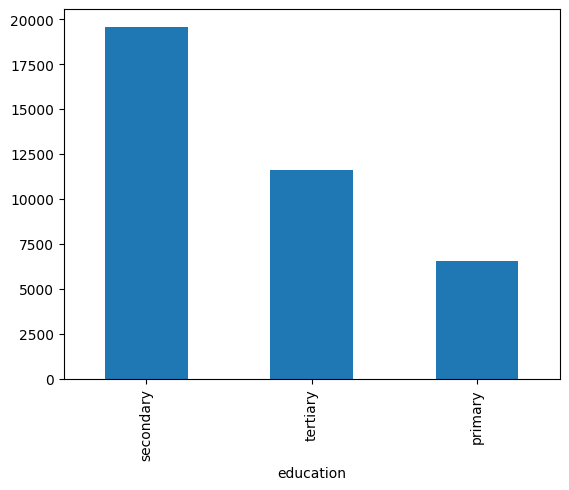

In [8]:
print('education has no null values : ' , train['education'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique education : ' , train['education'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('education value counts: ' , train['education'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['education'].value_counts().plot(kind='bar')


train['education']=train['education'].replace(np.nan , 'primary')

test['education']=test['education'].replace(np.nan , 'primary')

# default


default has no null values :  0

---------------------------------------------------------------------------

 Unique default :  ['no' 'yes']

---------------------------------------------------------------------------

default value counts:  default
no     36954
yes     2257
Name: count, dtype: int64

---------------------------------------------------------------------------



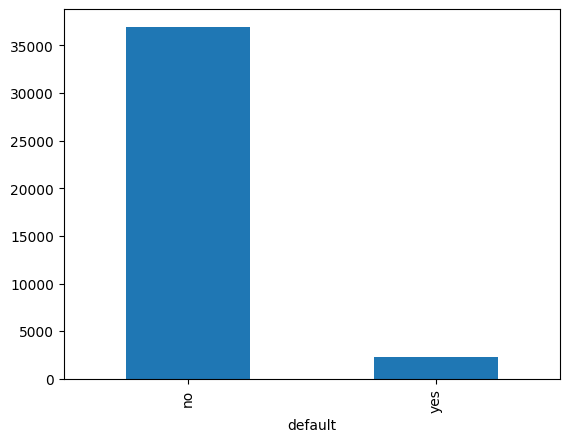

In [9]:
print('default has no null values : ' , train['default'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique default : ' , train['default'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('default value counts: ' , train['default'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['default'].value_counts().plot(kind='bar')
plt.show()


train['default'] = train['default'].map({'no': 0, 'yes': 1})


test['default'] = test['default'].map({'no': 0, 'yes': 1})


# housing

housing has no null values :  0

---------------------------------------------------------------------------

 Unique housing :  ['yes' 'no']

---------------------------------------------------------------------------

housing value counts:  housing
yes    21657
no     17554
Name: count, dtype: int64

---------------------------------------------------------------------------



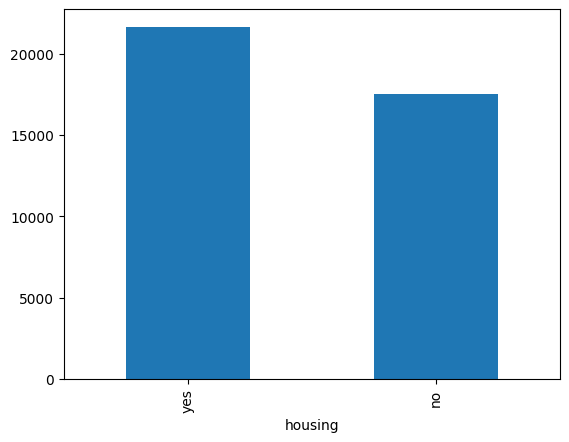

In [10]:
print('housing has no null values : ' , train['housing'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique housing : ' , train['housing'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('housing value counts: ' , train['housing'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['housing'].value_counts().plot(kind='bar')
plt.show()

train['housing'] = train['housing'].map({'no': 0, 'yes': 1})



test['housing'] = test['housing'].map({'no': 0, 'yes': 1})


loan has no null values :  0

---------------------------------------------------------------------------

 Unique loan :  ['no' 'yes']

---------------------------------------------------------------------------

loan value counts:  loan
no     31820
yes     7391
Name: count, dtype: int64

---------------------------------------------------------------------------



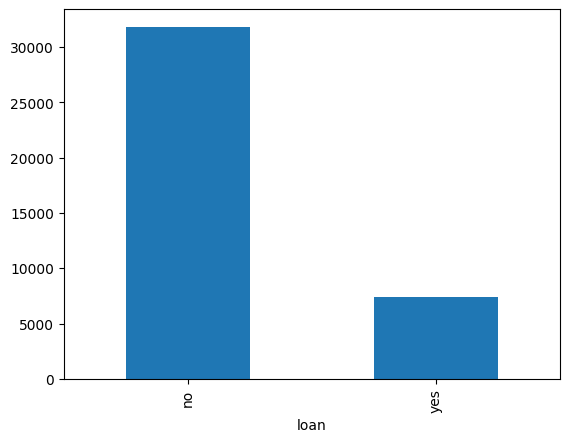

In [11]:
print('loan has no null values : ' , train['loan'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique loan : ' , train['loan'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('loan value counts: ' , train['loan'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['loan'].value_counts().plot(kind='bar')
plt.show()




train['loan'] = train['loan'].map({'no': 0, 'yes': 1})


test['loan'] = test['loan'].map({'no': 0, 'yes': 1})



contact has null values :  10336

---------------------------------------------------------------------------

 Unique contact :  ['cellular' 'telephone' nan]

---------------------------------------------------------------------------

contact value counts:  contact
cellular     25030
telephone     3845
Name: count, dtype: int64

---------------------------------------------------------------------------



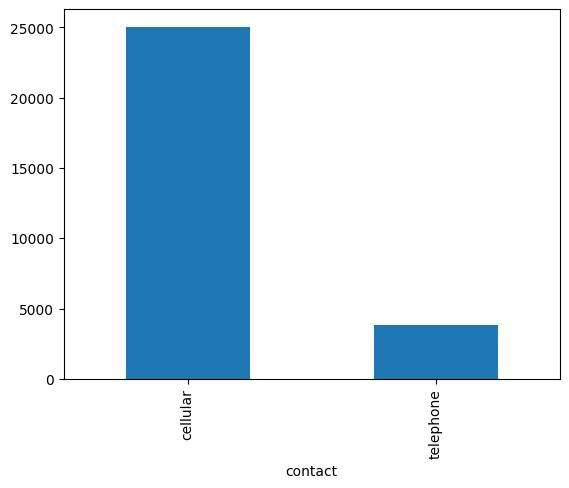

In [12]:
print('contact has null values : ' , train['contact'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique contact : ' , train['contact'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('contact value counts: ' , train['contact'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['contact'].value_counts().plot(kind='bar')
plt.show()


train['contact']=train['contact'].replace(np.nan , 'telephone')

train['contact'] = train['contact'].map({'cellular': 1, 'telephone': 0})



test['contact']=test['contact'].replace(np.nan , 'telephone')
test['contact'] = test['contact'].map({'cellular': 1, 'telephone': 0})



poutcome has  null values :  29451

---------------------------------------------------------------------------

 Unique poutcome :  ['other' nan 'failure' 'success']

---------------------------------------------------------------------------

poutcome value counts:  poutcome
failure    4949
other      2560
success    2251
Name: count, dtype: int64

---------------------------------------------------------------------------



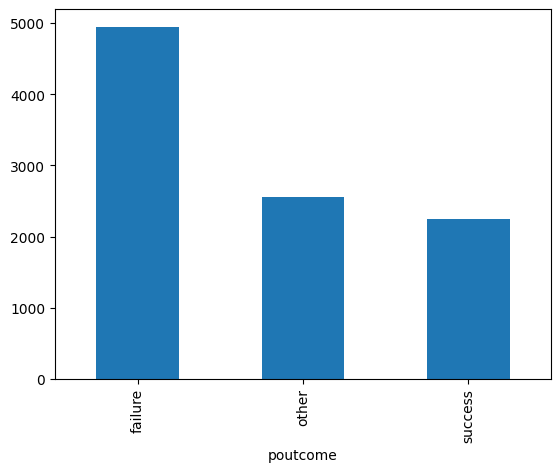

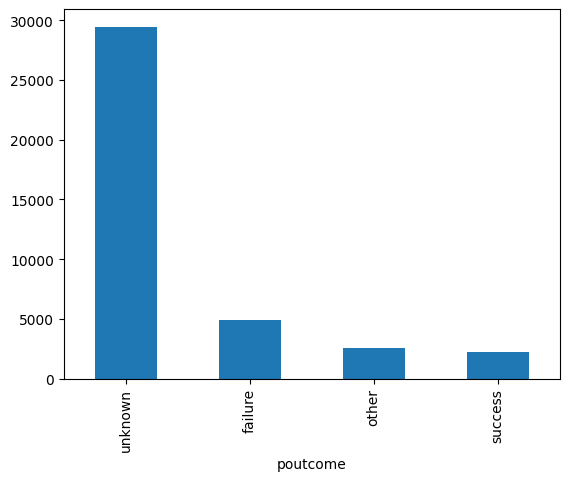

In [13]:
print('poutcome has  null values : ' , train['poutcome'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique poutcome : ' , train['poutcome'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('poutcome value counts: ' , train['poutcome'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['poutcome'].value_counts().plot(kind='bar')
plt.show()



train['poutcome'] = train['poutcome'].replace(np.nan, 'unknown')


train['poutcome'].value_counts().plot(kind='bar')
plt.show()



test['poutcome'] = test['poutcome'].replace(np.nan, 'unknown')


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   last contact date  39211 non-null  object
 1   age                39211 non-null  int64 
 2   job                39211 non-null  object
 3   marital            39211 non-null  object
 4   education          39211 non-null  object
 5   default            39211 non-null  int64 
 6   balance            39211 non-null  int64 
 7   housing            39211 non-null  int64 
 8   loan               39211 non-null  int64 
 9   contact            39211 non-null  int64 
 10  duration           39211 non-null  int64 
 11  campaign           39211 non-null  int64 
 12  pdays              39211 non-null  int64 
 13  previous           39211 non-null  int64 
 14  poutcome           39211 non-null  object
 15  target             39211 non-null  object
dtypes: int64(10), object(6)
memory usage: 4.

# Numerical Columns
# Age , Balance , campaign , pdays , previous

Age has no null values :  0

---------------------------------------------------------------------------

no. of age less than zero is  0

---------------------------------------------------------------------------

 Unique Ages :  [26 52 44 33 31 25 46 37 38 32 28 34 86 42 58 39 35 47 45 48 30 50 56 54
 40 53 41 51 27 29 57 63 36 43 19 55 49 23 83 60 22 80 76 59 24 93 71 89
 64 68 85 79 62 69 20 90 66 87 72 88 67 70 77 91 78 61 65 73 74 84 82 92
 81 18 21 75 94 95]

---------------------------------------------------------------------------

Age value counts:  age
32    1688
31    1629
33    1599
35    1571
34    1566
      ... 
18      44
92      41
87      40
85      39
95       2
Name: count, Length: 78, dtype: int64

---------------------------------------------------------------------------



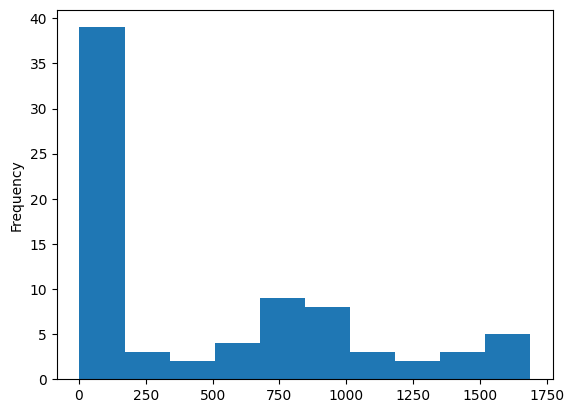

In [15]:
print('Age has no null values : ' , train['age'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print('no. of age less than zero is ', train[train['age']<0]['age'].count())


print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique Ages : ' , train['age'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('Age value counts: ' , train['age'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['age'].value_counts().plot(kind='hist')
plt.show()




# Feature Engineering Age Category

In [16]:
def age_category(x):
    if x<=39:
        return 'young'
    if 40<=x<=59:
        return 'middle'
    return 'old'


train['Age_Category'] = train['age'].apply(age_category)

test['Age_Category'] = test['age'].apply(age_category)



campaign has no null values :  0

---------------------------------------------------------------------------

camaign less than zero is  0

---------------------------------------------------------------------------

 Unique campaign  :  [ 2  1  3  4  6 45  5 44 12 61 58  7  8 20 43 17 13 15 48 34 11 54 22 26
 29 21 10 49  9 52 53 57 16 50 46 47 23 37 18 38 32 36 39 56 14 30 41 63
 51 28 25 62 55 42 35 31 59 19 40 33 24 27 60]

---------------------------------------------------------------------------

campaign value counts:  campaign
1     14013
2     10016
3      4470
4      2861
5      1469
      ...  
48       44
30       43
40       43
60       43
53       38
Name: count, Length: 63, dtype: int64

---------------------------------------------------------------------------



<Axes: ylabel='Frequency'>

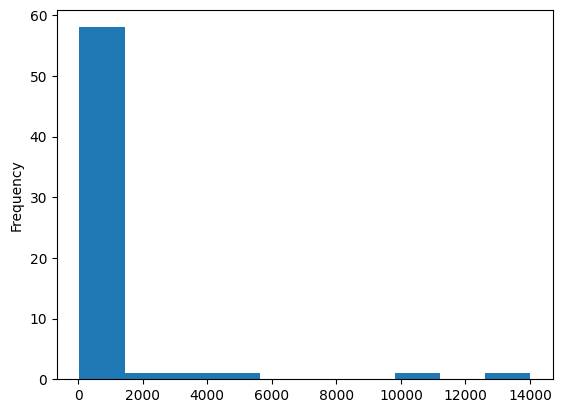

In [17]:
print('campaign has no null values : ' , train['campaign'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')


print('camaign less than zero is ', train[train['campaign']<0]['campaign'].count())


print('')
print('---------------------------------------------------------------------------')
print('')
print(' Unique campaign  : ' , train['campaign'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('campaign value counts: ' , train['campaign'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['campaign'].value_counts().plot(kind='hist')



balance has no null values :  0

---------------------------------------------------------------------------

checking if balance is negetive and how many rows have balance less than zero: 2971

---------------------------------------------------------------------------

 Unique balance values :  [  647   553  1397 ...  4307  6187 38594]

---------------------------------------------------------------------------

balance value counts:  balance
0        2799
1         149
2         122
4         115
3         104
         ... 
95094       1
81074       1
31565       1
5278        1
38594       1
Name: count, Length: 9535, dtype: int64

---------------------------------------------------------------------------



<Axes: ylabel='Frequency'>

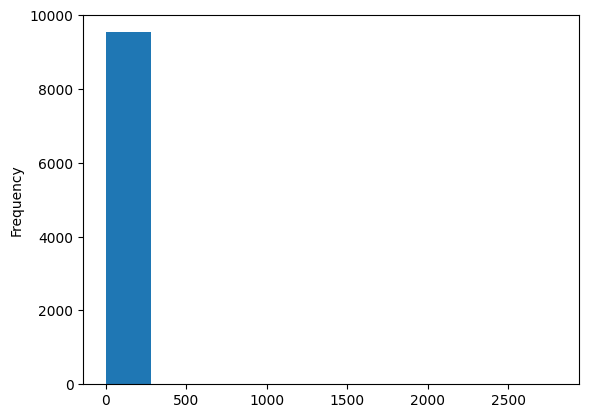

In [18]:
print('balance has no null values : ' , train['balance'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print('checking if balance is negetive and how many rows have balance less than zero:'  , train[train['balance']<0]['balance'].count())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique balance values : ' , train['balance'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('balance value counts: ' , train['balance'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['balance'].value_counts().plot(kind='hist')







pdays has no null values :  0

---------------------------------------------------------------------------

 Unique pdays values :  [331  -1 852 661 152 599 365 367 238 129 287 174 120 368 371 187 610 364
 633  80 125 356 248 186 278 154  90  98 574 352 561 260 801  78 596 343
 671 175 159  12 111  31 342 357  74 100 289  84 109 245 369  83 536 216
  89  97 252 143 378 336 172 160 191  91 848 258 317  94 196 362 188 272
 138 298 116 101 591 360 234 505 631  82   8 300 472 173 530 103 236 316
 370 611 271 305  79 474 405 293 442 178 232 299 213 184 237  93  37 255
 353 259 181 315 147 349 335 165 295 203 290   6 767 302 169 320 148  19
 435 328 645 526 150 318 347  29  96 254  35 136 350 759 358 670 348 224
 114 102 407 326 330 665 760 445 373 265 190 285 246 644 337 161 264 562
 189 363 630 652  44 478 322 176 783 597 344 339 110 334 167 204 166 816
 484 177 775 366  32 480 200 408 421 247 291 261 579 244 730 324 434 525
 156 153 157  95 439 286 163 197 182 309 257 283 461 824  92 704 

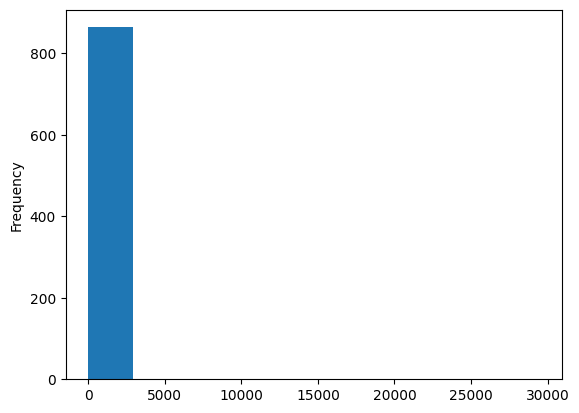

In [19]:
print('pdays has no null values : ' , train['pdays'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')

print(' Unique pdays values : ' , train['pdays'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('pdays value counts: ' , train['pdays'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['pdays'].value_counts().plot(kind='hist')



train['previously_contacted'] = train['pdays'].apply(lambda x: 1 if x != -1 else 0)

test['previously_contacted'] = test['pdays'].apply(lambda x: 1 if x != -1 else 0)


previous has no null values :  0

---------------------------------------------------------------------------

checking if previous is negetive and how many rows have previous less than zero: 0

---------------------------------------------------------------------------

 Unique previous  :  [  1   0   4 143 234   3  18   2 225 219   6  12  16 248 217 116   8 119
  37  69 113  14 265 175 103  28  86   5 196 156 207 218 148 213  87 241
  60 235 172 255 266  17 135  99  20   9 270 229 188 105 141 153 131 182
 223 177  70  75   7  91 236  85 100 160  30  63 178 150  72 233  40 145
 272  24 249  97 193 140 222 128  90  10 155 122 134 252 117 173 203 226
  23 194 208  77 274  38 273 244  15 176  96  31 133 259 191 101 197 192
 152 216 204 206  71 180 250 268 144  81 110 136  43  19  74 187 205  66
 269  36 166  29  53 200 261  13  61 186  62 104 138 123  78 189 147 185
 179 129 190 111 139 211 245  22  51 171  26 254  84 174  46  48  58  68
 228  11  80  55 107 232 202 132 264  56 260 181  

<Axes: ylabel='Frequency'>

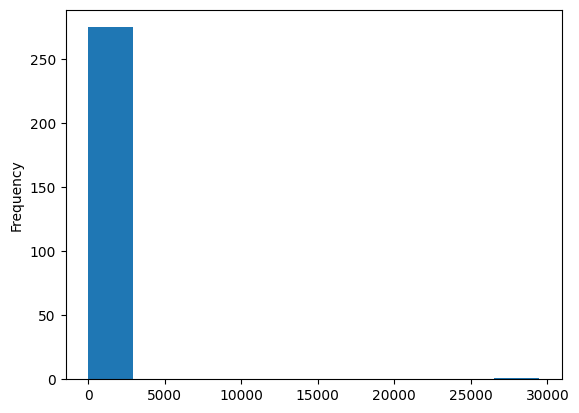

In [20]:
print('previous has no null values : ' , train['previous'].isnull().sum())

print('')
print('---------------------------------------------------------------------------')
print('')


print('checking if previous is negetive and how many rows have previous less than zero:'  , train[train['previous']<0]['previous'].count())


print('')
print('---------------------------------------------------------------------------')
print('')


print(' Unique previous  : ' , train['previous'].unique())

print('')
print('---------------------------------------------------------------------------')
print('')

print('previous value counts: ' , train['previous'].value_counts())

print('')
print('---------------------------------------------------------------------------')
print('')

train['previous'].value_counts().plot(kind='hist')


In [21]:
print('Shape:', train.shape)
print('')
print('---------------------------------------------------------------------------')
print('')
print(train.info())
print('')
print('---------------------------------------------------------------------------')
print('')
train.describe()

Shape: (39211, 18)

---------------------------------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39211 entries, 0 to 39210
Data columns (total 18 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   last contact date     39211 non-null  object
 1   age                   39211 non-null  int64 
 2   job                   39211 non-null  object
 3   marital               39211 non-null  object
 4   education             39211 non-null  object
 5   default               39211 non-null  int64 
 6   balance               39211 non-null  int64 
 7   housing               39211 non-null  int64 
 8   loan                  39211 non-null  int64 
 9   contact               39211 non-null  int64 
 10  duration              39211 non-null  int64 
 11  campaign              39211 non-null  int64 
 12  pdays                 39211 non-null  int64 
 13  previous              39211 non-null  i

,age,default,balance,housing,loan,contact,duration,campaign,pdays,previous,previously_contacted
count,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000,39211.000000
mean,42.120247,0.057560,5441.781719,0.552320,0.188493,0.638341,439.062789,5.108770,72.256051,11.826171,0.249037
std,12.709352,0.232913,16365.292065,0.497261,0.391110,0.480487,769.096291,9.890153,160.942593,44.140259,0.432461
min,18.000000,0.000000,-8019.000000,0.000000,0.000000,0.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,33.000000,0.000000,98.000000,0.000000,0.000000,0.000000,109.000000,1.000000,-1.000000,0.000000,0.000000
50%,40.000000,0.000000,549.000000,1.000000,0.000000,1.000000,197.000000,2.000000,-1.000000,0.000000,0.000000
75%,50.000000,0.000000,2030.000000,1.000000,0.000000,1.000000,380.000000,4.000000,-1.000000,0.000000,0.000000
max,95.000000,1.000000,102127.000000,1.000000,1.000000,1.000000,4918.000000,63.000000,871.000000,275.000000,1.000000


# Column Transformer

In [22]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler , OneHotEncoder  , LabelEncoder, RobustScaler , OrdinalEncoder

col_transformer=ColumnTransformer(transformers=[
    
    ('numerical_cols' , RobustScaler(),['age','balance','campaign','previous', 'duration']), 
    ('categorical_cols' , OneHotEncoder(handle_unknown='ignore',sparse_output=False),['job','marital','poutcome']),
    ('label_cols', OrdinalEncoder(),['education' , 'Age_Category'])
   
    
])

In [23]:
train

,last contact date,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,target,Age_Category,previously_contacted
0,2009-04-17,26,blue-collar,married,secondary,0,647,1,0,1,357,2,331,1,other,no,young,1
1,2009-10-11,52,technician,married,secondary,0,553,1,0,0,160,1,-1,0,unknown,no,middle,0
2,2010-11-20,44,blue-collar,married,secondary,0,1397,0,0,1,326,1,-1,0,unknown,no,middle,0
3,2009-09-01,33,admin.,married,secondary,0,394,1,0,0,104,3,-1,0,unknown,no,young,0
4,2008-01-29,31,entrepreneur,single,tertiary,0,137,0,0,1,445,2,-1,0,unknown,no,young,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39206,2008-07-31,31,technician,single,secondary,0,0,1,0,1,16,34,-1,0,unknown,no,young,0
39207,2009-07-31,59,admin.,married,primary,0,6187,0,0,1,114,4,-1,0,unknown,no,middle,0
39208,2008-06-02,36,blue-collar,married,secondary,0,63,1,0,0,56,8,-1,0,unknown,no,young,0
39209,2010-03-20,28,student,single,secondary,0,5916,0,0,1,93,5,-1,0,unknown,no,young,0


In [24]:

train_yes=train[train['target']=='no'].sample(5827 , random_state=42)
train_no=train[train['target']=='yes']

train= pd.concat([train_yes, train_no])


In [25]:
train.shape

(11654, 18)

In [26]:
y=train['target']

# duration
train=train[['age','balance','campaign','previous','duration' ,'job','marital','poutcome' ,'education','previously_contacted' ,'default','housing','loan','contact' ,'Age_Category']]



# duration
test=test[['age','balance','campaign','previous','duration' ,'job','marital','poutcome' ,'education','previously_contacted' ,'default','housing','loan','contact' ,'Age_Category']]


In [27]:
print(y.value_counts())

target
no     5827
yes    5827
Name: count, dtype: int64


In [28]:
train

,age,balance,campaign,previous,duration,job,marital,poutcome,education,previously_contacted,default,housing,loan,contact,Age_Category
228,27,3096,4,1,62,student,single,failure,secondary,1,0,1,0,0,young
13212,38,207,2,0,76,technician,single,unknown,secondary,0,0,0,0,0,young
9207,33,2548,2,0,179,admin.,single,unknown,secondary,0,0,1,0,1,young
20235,49,687,6,0,65,entrepreneur,married,unknown,secondary,0,0,0,0,1,middle
24063,43,0,3,0,75,management,divorced,unknown,secondary,0,0,0,0,1,middle
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39169,45,4831,11,0,479,management,single,unknown,tertiary,0,0,0,0,1,middle
39181,34,4499,1,0,1681,retired,married,unknown,primary,0,0,0,0,0,young
39201,26,81,2,0,803,blue-collar,single,unknown,secondary,0,1,0,1,1,young
39205,34,899,1,3,114,admin.,married,failure,tertiary,1,0,1,0,0,young


In [29]:
print('train shape : ',train.shape)

print('test shape : ',test.shape) 

train shape :  (11654, 15)
test shape :  (10000, 15)


In [30]:
train=col_transformer.fit_transform(train)
test=col_transformer.transform(test)


print('train shape : ', train.shape)

print('test shape : ' ,test.shape)

train shape :  (11654, 25)
test shape :  (10000, 25)


# train test split

In [31]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score


xtrain , xtest , ytrain , ytest = train_test_split(train , y ,test_size=0.3, random_state=1 , shuffle=True , stratify=y)

In [32]:
# from imblearn.over_sampling import SMOTE

# smote= SMOTE(sampling_strategy='minority', random_state=42)

# xtrain , ytrain = smote.fit_resample(xtrain , ytrain)


In [33]:
xtrain.shape

(8157, 25)

In [34]:
ytrain.shape

(8157,)

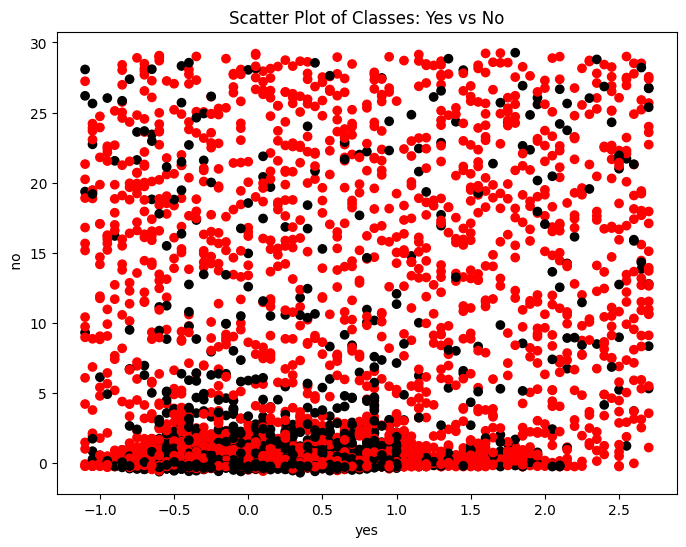

In [35]:
plt.figure(figsize=(8,6))



colors={   'yes':'red' ,  'no' : 'black'}

plt.scatter(xtrain[:,0],xtrain[:,1],c=ytrain.map(colors))

plt.title('Scatter Plot of Classes: Yes vs No')


plt.xlabel('yes')
plt.ylabel(' no')
plt.show()


In [36]:
from sklearn.linear_model import LogisticRegressionCV

from imblearn.pipeline import Pipeline 

from sklearn.metrics import classification_report , confusion_matrix , ConfusionMatrixDisplay

logistic = LogisticRegressionCV(cv=5, random_state=1 ,solver='liblinear' , class_weight='balanced' , max_iter=1000 , penalty='l1' ,Cs=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100] )

# logistic=Pipeline(steps=[('col_transformer',col_transformer),('logisticRegressionCV',logisticRegressionCV)])


logistic.fit(xtrain, ytrain)
ypredicted_logistic=logistic.predict(xtest)

print(   'logisticRegressionCV Score'   ,  logistic.score(xtest,ytest)  )


print(   'logisticRegressionCV f1_score '  ,     f1_score(ytest, ypredicted_logistic  , average='weighted')    )

print('Classification Report' ,classification_report(ytest ,ypredicted_logistic ) )

logisticRegressionCV Score 0.7555047183299971
logisticRegressionCV f1_score  0.7526375155312948
Classification Report               precision    recall  f1-score   support

          no       0.71      0.86      0.78      1748
         yes       0.83      0.65      0.73      1749

    accuracy                           0.76      3497
   macro avg       0.77      0.76      0.75      3497
weighted avg       0.77      0.76      0.75      3497



In [37]:
ytrain.value_counts()

target
no     4079
yes    4078
Name: count, dtype: int64

In [38]:
# from sklearn.svm import SVC
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import f1_score
# from sklearn.model_selection import GridSearchCV

# # # # param_grid = {'svc__C': [0.01, 0.1, 1, 10] }
# param_grid = {'svc__C': [0.1] }
# # # # svc_grid.best_params_
# # # # {'svc__C': 0.1}
# # # # svc_grid Score 0.8596381641857229
# # # # svc_grid f1_score  0.8596381641857229


# svc=Pipeline(steps=[('col_transformer',col_transformer),('svc',SVC(random_state=1 , class_weight='balanced' ))])

# svc_grid = GridSearchCV(svc, param_grid, scoring='f1_weighted', cv=5)

# svc_grid.fit(xtrain, ytrain)

# ypredicted_svc=svc_grid.predict(xtest)


# # svc_grid.fit(xtrain, ytrain)


# print(   'svc_grid Score'   ,  svc_grid.score(xtest,ytest)  )


# print(   'svc_grid f1_score '  ,     f1_score(ytest, ypredicted_svc  , average='weighted')    )

In [39]:
# from xgboost import XGBClassifier

# bst = XGBClassifier(n_estimators=2, max_depth=2, learning_rate=1, objective='binary:logistic')

# ytrain_numeric = ytrain.map({'yes': 1, 'no': 0})
# ytest_numeric = ytest.map({'yes': 1, 'no': 0})

# xbst=Pipeline(steps=[('col_transformer',col_transformer),('bst',bst)])

# xbst.fit(xtrain, ytrain_numeric)

# ypredicted_xbst=xbst.predict(xtest)

# print(   'svc Score'   ,  xbst.score(xtest,ytest_numeric)  )

# print(   'svc f1_score '  ,     f1_score(ytest_numeric, ypredicted_xbst  , average='weighted')    )

svc Score 0.8084072061767229
svc f1_score  0.8079234488159318
Classification Report               precision    recall  f1-score   support

          no       0.78      0.86      0.82      1748
         yes       0.84      0.76      0.80      1749

    accuracy                           0.81      3497
   macro avg       0.81      0.81      0.81      3497
weighted avg       0.81      0.81      0.81      3497

Confusion Matrix


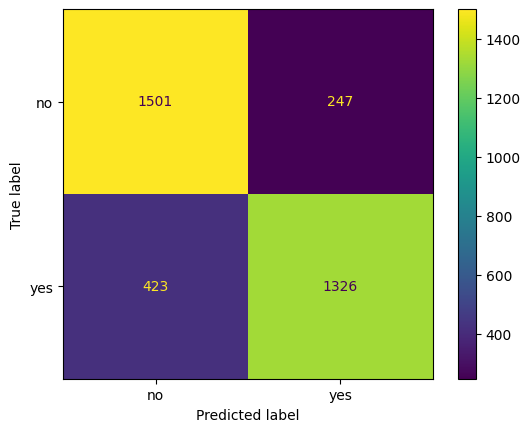

In [40]:
from sklearn.svm import SVC , LinearSVC
# svc=Pipeline(steps=[('col_transformer',col_transformer),('svc',SVC(random_state=1 , class_weight='balanced' ))])

svc=SVC(random_state=1 , class_weight='balanced' , C=10 )
svc.fit(xtrain, ytrain)

ypredicted_svc=svc.predict(xtest)

print(   'svc Score'   ,  svc.score(xtest,ytest)  )

print(   'svc f1_score '  ,     f1_score(ytest, ypredicted_svc  , average='weighted')    )


print('Classification Report' ,classification_report(ytest ,ypredicted_svc ) )

print('Confusion Matrix')
ConfusionMatrixDisplay.from_estimator(svc,xtest,ytest)

In [41]:
# Calculate the number of components that explain 95% of the variance
# pca = PCA(n_components=0.95)
# X_train_pca = pca.fit_transform(xtrain)

# # Number of components chosen
# print(f"Number of components explaining 95% variance: {pca.n_components_}")


In [42]:
# from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# # Assuming X_train is your data
# pca = PCA().fit(xtrain)

# # Plot the explained variance ratio for each component
# plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
# plt.xlabel('Number of Components')
# plt.ylabel('Cumulative Explained Variance')
# plt.grid(True)
# plt.show()


In [43]:
# from sklearn.svm import SVC , LinearSVC


# svc=SVC(random_state=1 , class_weight='balanced' , C=10 )

# svc=Pipeline(steps=[('pca', PCA(n_components=4)),('svc', svc)])

# svc.fit(xtrain, ytrain)

# ypredicted_svc=svc.predict(xtest)

# print(   'svc Score'   ,  svc.score(xtest,ytest)  )

# print(   'svc f1_score '  ,     f1_score(ytest, ypredicted_svc  , average='weighted')    )


# print('Classification Report' ,classification_report(ytest ,ypredicted_svc ) )

# print('Confusion Matrix')
# ConfusionMatrixDisplay.from_estimator(svc,xtest,ytest)

In [44]:
# params_svc = { 'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
#     'kernel': ['rbf', 'poly', 'linear'] }


# svc=LinearSVC(random_state=1 , class_weight='balanced' , C=10 , max_iter=1000 , shrinking=False)

# grid_svc = GridSearchCV(svc , params_svc, refit=True, verbose=3)
# grid_svc.fit(xtrain, ytrain)




# ypredicted_grid_svc=grid_svc.predict(xtest)

# print(   'grid_svc Score'   ,grid_svc.score(xtest,ytest)  )

# print(   'grid_svc f1_score '  ,f1_score(ytest, ypredicted_grid_svc  , average='weighted')    )


# print('Classification Report grid_svc')

# print(classification_report(ytest ,ypredicted_grid_svc))

# print('Confusion Matrix grid_svc')
# ConfusionMatrixDisplay.from_estimator(grid,xtest,ytest)

In [45]:
# from sklearn.ensemble import GradientBoostingClassifier

# gradientBoostingClassifier=Pipeline([('col_transformer',col_transformer),('GradientBoostingClassifier',GradientBoostingClassifier(random_state=1))])
# gradientBoostingClassifier.fit(xtrain, ytrain)

# ypredicted_gb=gradientBoostingClassifier.predict(xtest)

# print(   'gradientBoostingClassifier Score'   ,  gradientBoostingClassifier.score(xtest,ytest)  )


# print(   'gradientBoostingClassifier f1_score '  ,     f1_score(ytest, ypredicted_gb  , average='weighted')    )


In [46]:
# from sklearn.ensemble import HistGradientBoostingClassifier
# histGradientBoostingClassifier=Pipeline([('col_transformer',col_transformer),('HistGradientBoostingClassifier',HistGradientBoostingClassifier(random_state=1))])
# histGradientBoostingClassifier.fit(xtrain, ytrain)

# ypredicted_hgb=histGradientBoostingClassifier.predict(xtest)

# print(   'histGradientBoostingClassifier Score'   ,  histGradientBoostingClassifier.score(xtest,ytest)  )


# print(   'histGradientBoostingClassifier f1_score '  ,     f1_score(ytest, ypredicted_hgb  , average='weighted')    )


In [47]:
# from sklearn.model_selection import cross_val_score

# # Perform 5-fold cross-validation
# cv_scores = cross_val_score(svc, xtrain, ytrain, cv=5, scoring='f1_weighted')

# # Print the cross-validation F1 score
# print("Cross-validation F1 scores: ", cv_scores)
# print("Mean cross-validation F1 score: ", cv_scores.mean())


randomForestClassifier Score 0.8158421504146411
randomForestClassifier f1_score  0.8158415179299751
Classification Report
              precision    recall  f1-score   support

          no       0.82      0.81      0.82      1748
         yes       0.81      0.82      0.82      1749

    accuracy                           0.82      3497
   macro avg       0.82      0.82      0.82      3497
weighted avg       0.82      0.82      0.82      3497

Confusion Matrix


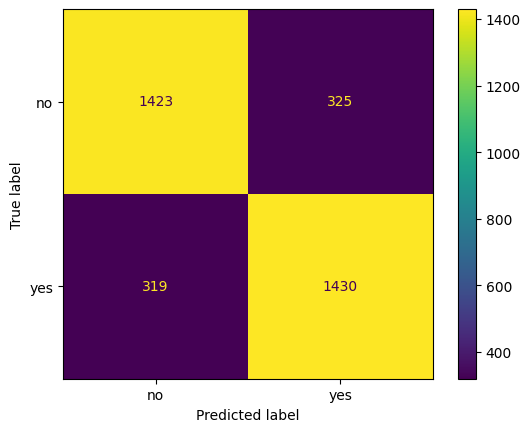

In [48]:
from sklearn.ensemble import RandomForestClassifier

# randomForestClassifier=Pipeline([('col_transformer',col_transformer),('randomForest',RandomForestClassifier(random_state=1))])
randomForestClassifier=RandomForestClassifier(random_state=1 , n_estimators=150, max_depth=5 , min_samples_split=3 , min_samples_leaf=3)
randomForestClassifier.fit(xtrain, ytrain)

ypredicted_rf=randomForestClassifier.predict(xtest)

print(   'randomForestClassifier Score'   ,  randomForestClassifier.score(xtest,ytest)  )


print(   'randomForestClassifier f1_score '  ,     f1_score(ytest, ypredicted_rf  , average='weighted')    )

print('Classification Report')

print(classification_report(ytest ,ypredicted_rf))

print('Confusion Matrix')

ConfusionMatrixDisplay.from_estimator(randomForestClassifier,xtest,ytest)


In [49]:
test

array([[-0.2       , -0.23244377, -0.25      , ...,  1.        ,
         2.        ,  2.        ],
       [-0.5       ,  0.07420265,  0.        , ...,  1.        ,
         2.        ,  2.        ],
       [-0.4       , -0.21074709,  0.5       , ...,  1.        ,
         1.        ,  2.        ],
       ...,
       [-0.7       , -0.18210747,  0.        , ...,  1.        ,
         1.        ,  2.        ],
       [-0.4       , -0.1442106 ,  0.        , ...,  1.        ,
         2.        ,  2.        ],
       [-0.1       ,  0.00361611,  0.75      , ...,  1.        ,
         1.        ,  2.        ]])

In [50]:
y_pred_submission=randomForestClassifier.predict(test)
# ypred_submission_xbst = pd.Series(y_pred_submission).replace({0: 'no', 1: 'yes'})

submission=pd.DataFrame({'id': np.arange(0,len(test)), 'target': y_pred_submission})

submission.to_csv('submission.csv',index=False)